# Classifiying Tweets - Kaggle Competiton
The *Natural Language Processing with Disaster Tweets* hosted on Kaggle is meant to give data scientist a manageable exercise to practice machine learning skills on a classifacation problem. The dataset, provided by 'Data for Everyone', contains a training and test set of tweets.

The objective of the competition is to classify the tweets contained in the test set as being related to disasters versus non-disater related tweets. The training set contains 10,000 hand-classified Tweets while the test set contains 3,243 unclassified tweets. Below you can find my code that implements a recurrent neural network architecture.

Submissions are scored using the F1 score.

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files, drive


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SimpleRNN, Dropout, Bidirectional, GRU, BatchNormalization
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from tensorflow.keras import regularizers
from sklearn.model_selection import KFold


drive_path = '/content/drive'
# Check if Google Drive is mounted and if not, mount it
if not os.path.ismount(drive_path):
    from google.colab import drive
    drive.mount(drive_path)
else:
    print("Google Drive is already mounted")

Google Drive is already mounted


Import the dataset from Kaggle

In [2]:
#Download Kaggle dataset
!pip install Kaggle #install kaggle API

#uplaod your Kaggle API key
files.upload()

#Kaggle API key
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [3]:
!kaggle competitions download -c nlp-getting-started

In [4]:
!unzip -o nlp-getting-started.zip

Archive:  nlp-getting-started.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


Read in dataset into dateframes

In [5]:
dataframes = {}

for filename in os.listdir('./'):
    if filename.endswith('.csv'):
        df_name = os.path.splitext(filename)[0]
        dataframes[df_name] = pd.read_csv(filename)

for name, df in dataframes.items():
    print(f"Loaded {name} with shape {df.shape}")
    globals()[name] = df

Loaded train with shape (7613, 5)
Loaded sample_submission with shape (3263, 2)
Loaded test with shape (3263, 4)


Make some directories theat we'll use later.



In [6]:
!mkdir -p 'models'
!mkdir -p 'logs'

# EDA, Cleaning, Pre-Processing
Let's see what the training data looks like.

In [7]:
print(test.head(25),"\n")

    id keyword                        location  \
0    0     NaN                             NaN   
1    2     NaN                             NaN   
2    3     NaN                             NaN   
3    9     NaN                             NaN   
4   11     NaN                             NaN   
5   12     NaN                             NaN   
6   21     NaN                             NaN   
7   22     NaN                             NaN   
8   27     NaN                             NaN   
9   29     NaN                             NaN   
10  30     NaN                             NaN   
11  35     NaN                             NaN   
12  42     NaN                             NaN   
13  43     NaN                             NaN   
14  45     NaN                             NaN   
15  46  ablaze                          London   
16  47  ablaze  Niall's place | SAF 12 SQUAD |   
17  51  ablaze                         NIGERIA   
18  58  ablaze                  Live On Webcam   


The training set has 7,613 total observations with target labels provided. It looks like the Tweets are alphabetized by keyowrd so we'll definitely want to shuffle data as we train the model.


In [8]:
print(train.info(),"\n")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None 



Let's take a look at the length of text strings and how many words appear in each string.

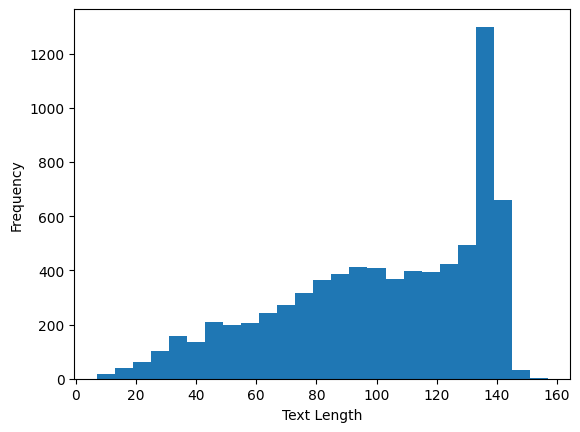

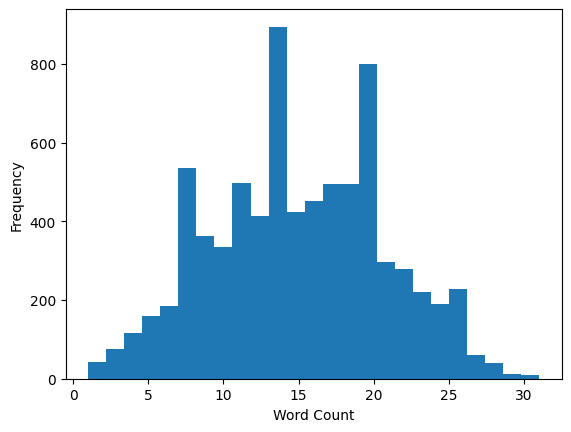

In [9]:
bins = 25

train['text_length'] = train['text'].apply(len)

plt.hist(train['text_length'], bins = bins)
plt.xlabel('Text Length')
plt.ylabel("Frequency")
plt.show()

train['word_count'] = train['text'].apply(lambda x: len(x.split()))

plt.hist(train['word_count'], bins = bins)
plt.xlabel('Word Count')
plt.ylabel("Frequency")
plt.show()

Now let's do some pre-processing:
*   Remove stopwords
*   Remove #, @ symbols but keep reference and hashtag text
*   Remove punctuation
*   Remove numbers
*   Remove urls
*   Perform stemming




In [10]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

nltk.download('punkt_tab')
nltk.download('stopwords')

def tweet_preprocess(text):
  # Remove URLs
  text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)

  # Remove user @ references and '#' from tweet
  text = re.sub(r'\@\w+|\#','', text)

  # Remove punctuations
  text = re.sub(r'[^\w\s]', '', text)

  # Remove numbers
  text = re.sub(r'\d+', '', text)

  # Tokenize into words
  words = word_tokenize(text)

  # Remove stopwords
  stop_words = set(stopwords.words('english'))
  words = [word for word in words if word not in stop_words]

  # Stemming
  stemmer = PorterStemmer()
  words = [stemmer.stem(word) for word in words]

  # Join words back to one string
  return ' '.join(words)


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [11]:
test_data = {
    'tweets': [
        "Check out our new blog at https://exampleblog.com #Tech",
        "Join the conversation with @user and explore #DataScience trends!",
        "Exciting news!!! Our team won first place in the competition -- details soon. @team #win",
        "We have over 1000 followers after only 2 weeks of launching our new campaign! #Success",
        "Running late to the meeting, but making progress on the project. The results are coming out great!"
    ]
}

pd.set_option('display.max_colwidth', None)  # None means no truncation
pd.set_option('display.max_rows', None)  # Display all rows

test_df = pd.DataFrame(test_data)
test_df['processed_tweets'] = test_df['tweets'].apply(tweet_preprocess)
print(test_df)

                                                                                               tweets  \
0                                             Check out our new blog at https://exampleblog.com #Tech   
1                                   Join the conversation with @user and explore #DataScience trends!   
2            Exciting news!!! Our team won first place in the competition -- details soon. @team #win   
3              We have over 1000 followers after only 2 weeks of launching our new campaign! #Success   
4  Running late to the meeting, but making progress on the project. The results are coming out great!   

                                            processed_tweets  
0                                        check new blog tech  
1                          join convers explor datasci trend  
2   excit news our team first place competit detail soon win  
3                 we follow week launch new campaign success  
4  run late meet make progress project the result come

In [12]:
pd.set_option('display.max_colwidth', 50)  # reset
pd.set_option('display.max_rows', 50)  # reset

Now run the function on our Tweet data

In [13]:
train['processed_tweets'] = test['text'].apply(tweet_preprocess)
test['processed_tweets'] = test['text'].apply(tweet_preprocess)

## Balancing the Training Data

We need to make sure the labeled data is balanced or else bias may be introduced. To explain, if one class has significantly fewer instances than another, then the model may develop a bias towards the majority class. In this case, incorrect predictions on the minority class could still give high model accuracy.

In [14]:
print(train.describe())

                 id      target  text_length   word_count
count   7613.000000  7613.00000  7613.000000  7613.000000
mean    5441.934848     0.42966   101.037436    14.903586
std     3137.116090     0.49506    33.781325     5.732604
min        1.000000     0.00000     7.000000     1.000000
25%     2734.000000     0.00000    78.000000    11.000000
50%     5408.000000     0.00000   107.000000    15.000000
75%     8146.000000     1.00000   133.000000    19.000000
max    10873.000000     1.00000   157.000000    31.000000


It looks like there are slightly more training instances labeled as '0'. Let's visualize this further:

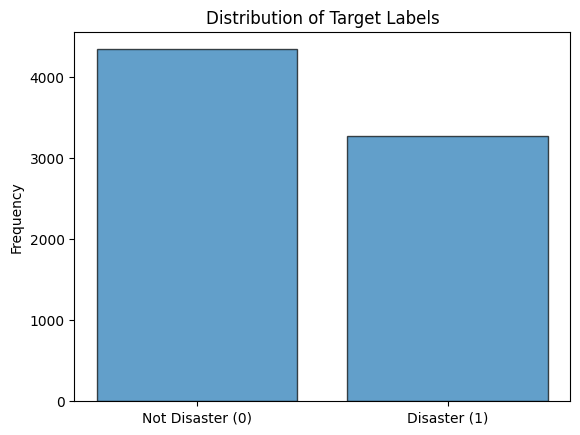

In [15]:
plt.hist(train['target'], bins=np.arange(-0.5, 2, 1), edgecolor='black', alpha=0.7, rwidth=0.8)
plt.xticks([0, 1], ['Not Disaster (0)', 'Disaster (1)'])
plt.ylabel('Frequency')
plt.title('Distribution of Target Labels')
plt.show()

In [49]:
#Balance the training data.
disasters = train[train['target'] == 1]
not_disasters = train[train['target'] == 0 ].sample(n=len(disasters), random_state=42)
balanced_train = pd.concat([disasters, not_disasters])
print(balanced_train.describe())

                 id       target  text_length   word_count
count   6542.000000  6542.000000  6542.000000  6542.000000
mean    5469.469734     0.500000   101.964078    14.940691
std     3133.513905     0.500038    33.165959     5.622304
min        1.000000     0.000000     7.000000     1.000000
25%     2793.750000     0.000000    79.000000    11.000000
50%     5431.000000     0.500000   108.000000    15.000000
75%     8162.750000     1.000000   134.000000    19.000000
max    10873.000000     1.000000   157.000000    31.000000


# Text Tokenization

To prepare the text data for training, a Keras Tokenizer is initialized with a vocabulary size limit of 10,000 words (num_words=10000). The tokenizer is fit on the training text data (balanced_train['text']) to create a word-to-index mapping.

After fitting, the training text is converted into sequences of integer tokens using texts_to_sequences(). The sequences are then padded to a consistent length based on the 95th percentile of sequence lengths (max_length) using pad_sequences() to ensure uniform input size for the model. This approach reduces computational load while preserving most of the sequence information.

In [ ]:
num_words= 10000
tokenizer = Tokenizer(num_words= num_words, oov_token="<OOV>")
tokenizer.fit_on_texts(balanced_train['text'])  # Fit the tokenizer on the training data

# tokenizer.fit_on_texts(train_data['text'])  # Fit the tokenizer on the training data
# vocab_size = len(tokenizer.word_index) + 1 #total words seen in the data
# print(vocab_size)

# Tokenize the training and validation data
train_sequences = tokenizer.texts_to_sequences(balanced_train['text'])
# valid_sequences = tokenizer.texts_to_sequences(valid_data['text'])

# print(train_sequences)
train_lengths = [len(seq) for seq in train_sequences]
max_length = int(np.percentile(train_lengths, 95))

# print(max_length)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post')
# valid_padded = pad_sequences(valid_sequences, maxlen=max_length, padding='post')

A new DataFrame train_processed is created by combining the original training text, labels, and padded sequences, ensuring that the number of rows matches the size of the original training data.

In [51]:
print(balanced_train.shape[0])
print(len(train_padded))
train_processed = pd.DataFrame({'text': balanced_train['text'], 'label': balanced_train['target'], 'padded': list(train_padded)})
# valid_processed = pd.DataFrame({'text': valid_data['text'], 'label': valid_data['label'], 'padded': list(valid_padded)})
print(train_processed.head())

6542
6542
                                                text  label  \
0  Our Deeds are the Reason of this #earthquake M...      1   
1             Forest fire near La Ronge Sask. Canada      1   
2  All residents asked to 'shelter in place' are ...      1   
3  13,000 people receive #wildfires evacuation or...      1   
4  Just got sent this photo from Ruby #Alaska as ...      1   

                                              padded  
0  [121, 4152, 24, 5, 985, 9, 22, 232, 137, 1573,...  
1  [175, 41, 206, 773, 6309, 6310, 1350, 0, 0, 0,...  
2  [46, 1574, 2610, 8, 6311, 7, 6312, 24, 135, 63...  
3  [845, 3216, 61, 4154, 1351, 233, 1258, 7, 83, ...  
4  [36, 110, 1173, 22, 334, 23, 6314, 1946, 30, 2...  


# Model Architectures


**LSTM1**

**Architecture:** Three stacked bidirectional LSTM layers with 128, 64, and 32 units, followed by dropout and a dense output layer. L2 regularization applied to the LSTM layers.

**Rationale:** Stacking multiple LSTM layers increases the model’s capacity to capture long-term dependencies and complex patterns in the data.

Bidirectional LSTM layers help the model leverage both past and future context, which is particularly useful for understanding sequence data.

Strong regularization and dropout help prevent overfitting due to the model's increased complexity.

**Potential Benefits:**

* Can capture complex long-term dependencies.

* Bidirectional nature improves contextual understanding.

**Potential Drawbacks:**

* High model complexity increases training time.

* More prone to overfitting if not properly regularized.


---


**LSTM2**

**Architecture:** Single bidirectional LSTM layer with 32 units, followed by dropout and a dense output layer.L2 regularization applied to the LSTM layer.

**Rationale:** Reducing the model depth decreases computational cost and training time while still allowing the model to capture temporal dependencies.

A simpler model is less prone to overfitting and may generalize better on smaller datasets.

**Potential Benefits:**
*   Faster training and inference.
*   Less prone to overfitting due to reduced complexity.

**Potential Drawbacks:**

*  Lower capacity to capture complex patterns compared to deeper models.

*  May underperform on complex datasets with long-term dependencies.


---


**GRU**

**Architecture:** Three stacked bidirectional GRU layers with 128, 64, and 32 units, followed by dropout and a dense output layer. L2 regularization applied to the GRU layers.

**Rationale:** GRU (Gated Recurrent Unit) layers are a computationally efficient alternative to LSTM layers with similar performance for sequence modeling.

GRUs have fewer parameters than LSTMs, which can improve training speed and reduce memory requirements.

Stacking GRU layers increases model capacity without the higher memory demands of LSTM.

**Potential Benefits:**
* More efficient than LSTM in terms of training time and memory.

* Suitable for capturing long-term dependencies with fewer parameters.

**Potential Drawbacks:**

* May slightly underperform compared to LSTM on very complex data.

* Stacked architecture increases computational cost compared to simpler models.

In [52]:
def train_LSTM1(data_x, data_y, param_combo, num_words, output_dim, lr, dropout_rate, batch_size, train_len, epochs):
  # first, convert input data to numpy arrays for Keras
  # train_data_x = np.array(train_data['padded'].tolist())
  # train_data_y = np.array(train_data['label'])
  # valid_data_x = np.array(valid_data['padded'].tolist())
  # valid_data_y = np.array(valid_data['label'])

  l2_rate = 0.01

  tf.keras.backend.clear_session()
  model = Sequential([
      Embedding(input_dim=num_words, output_dim=output_dim),
      Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=regularizers.l2(l2_rate))),
      Dropout(dropout_rate),
      Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=regularizers.l2(l2_rate))),
      Dropout(dropout_rate),
      Bidirectional(LSTM(32, kernel_regularizer=regularizers.l2(l2_rate))),
      Dropout(dropout_rate),
      Dense(units=1, activation='sigmoid')
  ])

  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate= lr,
                                                            decay_steps=train_len//batch_size, # Apply decay after each epoch
                                                            decay_rate=0.95)

  model.compile(
      optimizer=Adam(learning_rate = lr_schedule),
      loss='binary_crossentropy',
      metrics=['accuracy', 'Precision', 'Recall']
  )

  callbacks = [
      EarlyStopping(monitor = 'val_loss', patience = 1, restore_best_weights = True),
      ModelCheckpoint(filepath = f'/content/models/{param_combo}.keras', monitor = 'val_accuracy', save_best_only = True),
      CSVLogger(filename = f'/content/logs/{param_combo}.csv', separator = ',', append = False)
  ]

  history = model.fit(
    x=data_x[train_index],
    y=data_y[train_index],
    validation_data=(data_x[val_index],
                     data_y[val_index]),
    epochs = epochs,
    batch_size = int(batch_size),
    shuffle = True,
    callbacks = callbacks,
    )

  epochs_run = len(history.history['loss'])
  best_accuracy = max(history.history['val_accuracy'])

  new_row = pd.DataFrame({
    'Architecture' : 'LSTM1',
    'param_combo' : [param_combo],
    'learning_rate': [lr],
    'dropout_rate': [dropout_rate],
    'epochs run': [epochs_run],
    'ending_lr': model.optimizer.learning_rate.numpy(),
    'num_words': [num_words],
    'output_dim': [output_dim],
    'batch_size': [batch_size],
    'val_accuracy': [best_accuracy],
  })

  return model, new_row



In [53]:
def train_LSTM2(data_x, data_y, param_combo, num_words, output_dim, lr, dropout_rate, batch_size, train_len, epochs):
  # first, convert input data to numpy arrays for Keras
  # train_data_x = np.array(train_data['padded'].tolist())
  # train_data_y = np.array(train_data['label'])
  # valid_data_x = np.array(valid_data['padded'].tolist())
  # valid_data_y = np.array(valid_data['label'])

  l2_rate = 0.01

  tf.keras.backend.clear_session()
  model = Sequential([
      Embedding(input_dim=num_words, output_dim=output_dim),
      Bidirectional(LSTM(32, kernel_regularizer=regularizers.l2(l2_rate))),
      Dropout(dropout_rate),
      Dense(units=1, activation='sigmoid')
  ])

  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate= lr,
                                                            decay_steps=train_len//batch_size, # Apply decay after each epoch
                                                            decay_rate=0.95)

  model.compile(
      optimizer=Adam(learning_rate = lr_schedule),
      loss='binary_crossentropy',
      metrics=['accuracy', 'Precision', 'Recall']
  )

  callbacks = [
      EarlyStopping(monitor = 'val_loss', patience = 1, restore_best_weights = True),
      ModelCheckpoint(filepath = f'/content/models/{param_combo}.keras', monitor = 'val_accuracy', save_best_only = True),
      CSVLogger(filename = f'/content/logs/{param_combo}.csv', separator = ',', append = False)
  ]

  history = model.fit(
    x=data_x[train_index],
    y=data_y[train_index],
    validation_data=(data_x[val_index],
                     data_y[val_index]),
    epochs = epochs,
    batch_size = int(batch_size),
    shuffle = True,
    callbacks = callbacks,
    )

  epochs_run = len(history.history['loss'])
  best_accuracy = max(history.history['val_accuracy'])

  new_row = pd.DataFrame({
    'Architecture' : 'LSTM2',
    'param_combo' : [param_combo],
    'learning_rate': [lr],
    'dropout_rate': [dropout_rate],
    'epochs run': [epochs_run],
    'ending_lr': model.optimizer.learning_rate.numpy(),
    'num_words': [num_words],
    'output_dim': [output_dim],
    'batch_size': [batch_size],
    'val_accuracy': [best_accuracy],
  })

  return model, new_row



In [54]:
def train_GRU(data_x, data_y, param_combo, num_words, output_dim, lr, dropout_rate, batch_size, train_len, epochs):
  # first, convert input data to numpy arrays for Keras
  # train_data_x = np.array(train_data['padded'].tolist())
  # train_data_y = np.array(train_data['label'])
  # valid_data_x = np.array(valid_data['padded'].tolist())
  # valid_data_y = np.array(valid_data['label'])

  l2_rate = 0.01

  tf.keras.backend.clear_session()
  model = Sequential([
      Embedding(input_dim=num_words, output_dim=output_dim),
      Bidirectional(GRU(128, return_sequences=True, kernel_regularizer=regularizers.l2(l2_rate))),
      Dropout(dropout_rate),
      Bidirectional(GRU(64, return_sequences=True, kernel_regularizer=regularizers.l2(l2_rate))),
      Dropout(dropout_rate),
      Bidirectional(GRU(32, kernel_regularizer=regularizers.l2(l2_rate))),
      Dropout(dropout_rate),
      Dense(units=1, activation='sigmoid')
  ])

  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate= lr,
                                                            decay_steps=train_len//batch_size, # Apply decay after each epoch
                                                            decay_rate=0.95)

  model.compile(
      optimizer=Adam(learning_rate = lr_schedule),
      loss='binary_crossentropy',
      metrics=['accuracy', 'Precision', 'Recall']
  )

  callbacks = [
      EarlyStopping(monitor = 'val_loss', patience = 1, restore_best_weights = True),
      ModelCheckpoint(filepath = f'/content/models/{param_combo}.keras', monitor = 'val_accuracy', save_best_only = True),
      CSVLogger(filename = f'/content/logs/{param_combo}.csv', separator = ',', append = False)
  ]

  history = model.fit(
    x=data_x[train_index],
    y=data_y[train_index],
    validation_data=(data_x[val_index],
                     data_y[val_index]),
    epochs = epochs,
    batch_size = int(batch_size),
    shuffle = True,
    callbacks = callbacks,
    )

  epochs_run = len(history.history['loss'])
  best_accuracy = max(history.history['val_accuracy'])

  new_row = pd.DataFrame({
    'Architecture' : 'GRU',
    'param_combo' : [param_combo],
    'learning_rate': [lr],
    'dropout_rate': [dropout_rate],
    'epochs run': [epochs_run],
    'ending_lr': model.optimizer.learning_rate.numpy(),
    'num_words': [num_words],
    'output_dim': [output_dim],
    'batch_size': [batch_size],
    'val_accuracy': [best_accuracy],
  })

  return model, new_row



## Hyperparameter Tuning
Below we tune the model with a small amount of hyperparameters with only two values each. This approach was implemented for the sake of simplicity and time. In further work, many more parameters and model architectures could be investaged. The hyperparameters tuned here inlcude:
* **num_words** - Sets the maximum number of most frequent words retained in the vocabulary, influencing the input data's vectorization
* **output_dim** - Defines the size of the vector space for word embeddings, affecting how text features are represented
* **dropout_rate**  - Specifies the fraction of input units to drop during training, helping prevent overfitting by making the model less sensitive to specific features
* **batch_size** - Controls the number of training examples used per iteration, impacting training speed and model stability

### Learning Rate Tuning
During hyperparameter tuning, I tested learning rates of 0.001 and 0.0001. A learning rate of 0.001 resulted in immediate overfitting, with significantly higher training accuracy compared to validation accuracy, but it produced higher overall validation accuracy. In contrast, a learning rate of 0.0001 yielded more stable and consistent training and validation accuracy, but required longer training times and ultimately achieved similar accuracy to 0.001. Although the higher learning rate of 0.001 leads to overfitting, it consistently delivers better validation performance, making automated learning rate selection difficult. Therefore, the final model is chosen based on empirical performance despite signs of overfitting.

In [58]:
test_num_words = [num_words]
test_lr = [0.0001]
test_output_dim = [32,64]
test_dropout_rate = [0.2,0.5]
batch_size = [64,128]
train_len = len(balanced_train)

i = 0

# K-Fold Cross-Validation setup
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
data_x = np.array(train_processed['padded'].tolist())
data_y = np.array(train_processed['label'])

# Initialize a DataFrame to store results
results_df = pd.DataFrame()

# Define the fold index for unique naming
fold_index = 1

for train_index, val_index in kfold.split(data_x):
    for num_words_ in test_num_words:
        for lr_ in test_lr:
            for output_dim_ in test_output_dim:
                for dropout_rate_ in test_dropout_rate:
                    for batch_size_ in batch_size:
                        i += 1
                        print(f"*** PARAMETER TEST: {i} ***")
                        print("num_words:", num_words_)
                        print("lr:", lr_)
                        print("output_dim:", output_dim_)
                        print("dropout_rate:", dropout_rate_)
                        print("batch_size:", batch_size_)

                        # Train LSTM1
                        print("Architecture: LSTM1")
                        model, new_res = train_LSTM1(data_x, data_y,
                                                     num_words=num_words_,
                                                     param_combo=f"LSTM1_{i}",
                                                     output_dim=output_dim_,
                                                     lr=lr_,
                                                     dropout_rate=dropout_rate_,
                                                     batch_size=batch_size_,
                                                     train_len=len(data_x[train_index]),
                                                     epochs=5)
                        results_df = pd.concat([results_df, new_res], ignore_index=True)

                        # Train LSTM2
                        print("Architecture: LSTM2")
                        model, new_res = train_LSTM2(data_x, data_y,
                                                     num_words=num_words_,
                                                     param_combo=f"LSTM2_{i}",
                                                     output_dim=output_dim_,
                                                     lr=lr_,
                                                     dropout_rate=dropout_rate_,
                                                     batch_size=batch_size_,
                                                     train_len=len(data_x[train_index]),
                                                     epochs=5)
                        results_df = pd.concat([results_df, new_res], ignore_index=True)

                        # Train GRU
                        print("Architecture: GRU")
                        model, new_res = train_GRU(data_x, data_y,
                                                   num_words=num_words_,
                                                   param_combo=f"GRU_{i}",
                                                   output_dim=output_dim_,
                                                   lr=lr_,
                                                   dropout_rate=dropout_rate_,
                                                   batch_size=batch_size_,
                                                   train_len=len(data_x[train_index]),
                                                   epochs=5)
                        results_df = pd.concat([results_df, new_res], ignore_index=True)

    fold_index += 1  # Increment fold index after each full cycle of tests


*** PARAMETER TEST: 1 ***
num_words: 10000
lr: 0.0001
output_dim: 32
dropout_rate: 0.2
batch_size: 64
Architecture: LSTM1
Epoch 1/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - Precision: 0.3930 - Recall: 0.0471 - accuracy: 0.4877 - loss: 9.1208 - val_Precision: 0.8908 - val_Recall: 0.1575 - val_accuracy: 0.5569 - val_loss: 7.9022
Epoch 2/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - Precision: 0.7421 - Recall: 0.5301 - accuracy: 0.6666 - loss: 7.5192 - val_Precision: 0.7824 - val_Recall: 0.7801 - val_accuracy: 0.7754 - val_loss: 6.4176
Epoch 3/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - Precision: 0.8053 - Recall: 0.7282 - accuracy: 0.7733 - loss: 6.1450 - val_Precision: 0.8809 - val_Recall: 0.7474 - val_accuracy: 0.8182 - val_loss: 5.3466
Epoch 4/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - Precision: 0.8959 - Recall: 0.7362 - accuracy: 0.8293 - loss: 5.1106 - val_Precision: 0.9187 - val_Recall: 0.7221 - val_accuracy: 0.8243 - val_loss: 4.5184
Epoch 5/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/

Let's look at the hyperparameter tuning results

In [59]:
results_df[0:i]

,Architecture,param_combo,learning_rate,dropout_rate,epochs run,ending_lr,num_words,output_dim,batch_size,val_accuracy
0,LSTM1,LSTM1_1,0.0001,0.2,5,0.000077,10000,32,64,0.832697
1,LSTM2,LSTM2_1,0.0001,0.2,5,0.000077,10000,32,64,0.798319
2,GRU,GRU_1,0.0001,0.2,5,0.000077,10000,32,64,0.832697
3,LSTM1,LSTM1_2,0.0001,0.2,5,0.000077,10000,32,128,0.806723
4,LSTM2,LSTM2_2,0.0001,0.2,5,0.000077,10000,32,128,0.711230
5,GRU,GRU_2,0.0001,0.2,5,0.000077,10000,32,128,0.809778
6,LSTM1,LSTM1_3,0.0001,0.5,5,0.000077,10000,32,64,0.825821
7,LSTM2,LSTM2_3,0.0001,0.5,5,0.000077,10000,32,64,0.815126
8,GRU,GRU_3,0.0001,0.5,5,0.000077,10000,32,64,0.841864
9,LSTM1,LSTM1_4,0.0001,0.5,5,0.000077,10000,32,128,0.810542


In [60]:
range = min(results_df['val_accuracy']), max(results_df['val_accuracy'])
print(range)

(0.6432391405105591, 0.8479755520820618)


### Tuning Results

We can see a general trend the individual hyperparameter tuning model results. Most parameter cobinations begin with a lower training accuracy that increases to above 90% by the end of five epochs while the validation accuracy begins in 50-70% range and plateus in the upper 70s. This shows that the selected hyperparameter combinations lead the model to overfit after one epoch in many cases.

In [61]:
results_df.to_csv('hyperparameter_tuning_results.csv', index=False)

Store the best performing parameters

In [62]:
# Get the best row based on max accuracy
best_params = results_df.loc[results_df['val_accuracy'].idxmax()]
print(best_params)

# Extract values into named variables
best_arch = best_params['Architecture']
best_param_combo = best_params['param_combo']
best_num_words = best_params['num_words']
best_output_dim = best_params['output_dim']
best_lr = best_params['learning_rate']
best_dropout_rate = best_params['dropout_rate']
best_batch_size = best_params['batch_size']

Architecture          GRU
param_combo         GRU_5
learning_rate      0.0001
dropout_rate          0.2
epochs run              5
ending_lr        0.000077
num_words           10000
output_dim             64
batch_size             64
val_accuracy     0.847976
Name: 14, dtype: object


Retrain a model with the optimal parameters over more epochs to take a closer look

In [64]:
final_train_results = pd.DataFrame()
tf.keras.backend.clear_session()
model, results = train_GRU(data_x, data_y,
                            num_words=num_words,
                            param_combo = 'final',
                            output_dim = int(best_output_dim),
                            lr = 0.0001,
                            dropout_rate = best_dropout_rate,
                            batch_size = best_batch_size,
                            train_len = train_len,
                            epochs = 20
                            )

final_train_results = pd.concat([final_train_results, results], ignore_index=True)
final_train_results.to_csv('final_train_results.csv', index=False)
final_train_results.head()
#save model
model.save('final_model.keras')

Epoch 1/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - Precision: 0.4546 - Recall: 0.1242 - accuracy: 0.5136 - loss: 9.0705 - val_Precision: 0.6011 - val_Recall: 0.8465 - val_accuracy: 0.6544 - val_loss: 7.9229
Epoch 2/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Precision: 0.6720 - Recall: 0.8145 - accuracy: 0.7045 - loss: 7.5893 - val_Precision: 0.7061 - val_Recall: 0.7373 - val_accuracy: 0.7248 - val_loss: 6.6541
Epoch 3/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Precision: 0.7655 - Recall: 0.7491 - accuracy: 0.7580 - loss: 6.3213 - val_Precision: 0.7993 - val_Recall: 0.7184 - val_accuracy: 0.7768 - val_loss: 5.4919
Epoch 4/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - Precision: 0.8705 - Recall: 0.7798 - accuracy: 0.8279 - loss: 5.1895 - val_Precision: 0.8138 - val_Recall: 0.7263 - val_accuracy: 0.7875 - val_loss: 4.6523
Epoch 5/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - Precision: 0.9173 - Recall: 0.7840 - accuracy: 0.8560 - loss: 4.3719 - val_Precision: 0.8655 - val_Recall: 0.70

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 25, 64)              │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 25, 256)             │         148,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 25, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 25, 128)             │         123,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 25, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 64)                  │          31,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,831,428 (10.80 MB)

 Trainable params: 943,809 (3.60 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,887,619 (7.20 MB)

LEt's look at the model structure

In [76]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 25, 64)              │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 25, 256)             │         148,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 25, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 25, 128)             │         123,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 25, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 64)                  │          31,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,831,428 (10.80 MB)

 Trainable params: 943,809 (3.60 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,887,619 (7.20 MB)

## Training Results

The RNN model was trained using a specific combination of hyperparameters, labeled as GRU_5. It started with an initial learning rate of 0.0001, which decayed to 0.000077 by the end of training. The model utilized a vocabulary size of 10,000 words and an output dimension of 64 for embeddings, with a dropout rate set at 0.2 to prevent overfitting. The batch size for training was 64. These settings resulted in the model achieving an accuracy around 80% on the validation set.

After parameter tuning was complete, I decided to retrain the model using the full dataset over 20 epochs. This training gave slightly different, but overall similar results. This final model is used to make predictions.

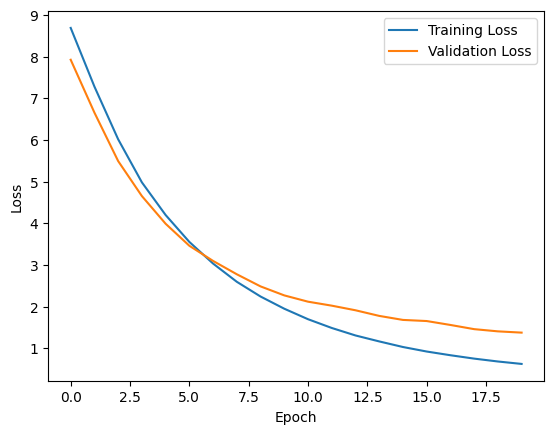

In [72]:
training_results = pd.read_csv('/content/logs/final.csv')
plt.plot(training_results['loss'], label='Training Loss')
plt.plot(training_results['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

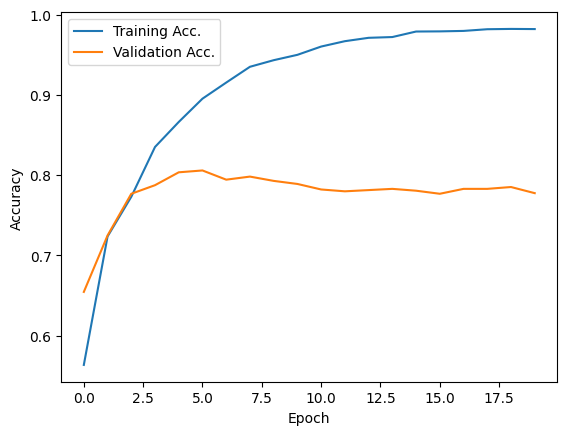

In [75]:
training_results = pd.read_csv('/content/logs/final.csv')
plt.plot(training_results['accuracy'], label='Training Acc.')
plt.plot(training_results['val_accuracy'], label='Validation Acc.')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Predictions
Prepare the test data for making predictions

In [43]:
# Get token sequences for the test data
tokenizer = Tokenizer(num_words = num_words, oov_token="<OOV>")
tokenizer.fit_on_texts(balanced_train['text'])

# Tokenize the training and validation data
test_sequences = tokenizer.texts_to_sequences(test['text'])

test_lengths = [len(seq) for seq in test_sequences]
max_length = int(np.percentile(test_lengths, 95))

# print(max_length)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post')

Make predictions on the Kaggle test set

In [65]:
predictions = model.predict(test_padded)

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


In [66]:
predictions = np.where(predictions >= 0.5, 1, 0)

In [67]:
submission = pd.DataFrame({'id': test['id'], 'target': predictions.flatten()})
submission.to_csv('submission.csv', index=False)
submission.head()

,id,target
0,0,1
1,2,0
2,3,1
3,9,1
4,11,1


In [68]:
!kaggle competitions submit -c nlp-getting-started -f submission.csv -m "Message"

100% 22.2k/22.2k [00:00<00:00, 57.5kB/s]
Successfully submitted to Natural Language Processing with Disaster Tweets

Here's my submission results on Kaggle:

Downloading...
From: https://drive.google.com/uc?id=1QLVEsu_FIxVX-8bUvzIutBpSHk_XRmOI
To: /content/downloaded_image.jpg
100%|██████████| 351k/351k [00:00<00:00, 118MB/s]


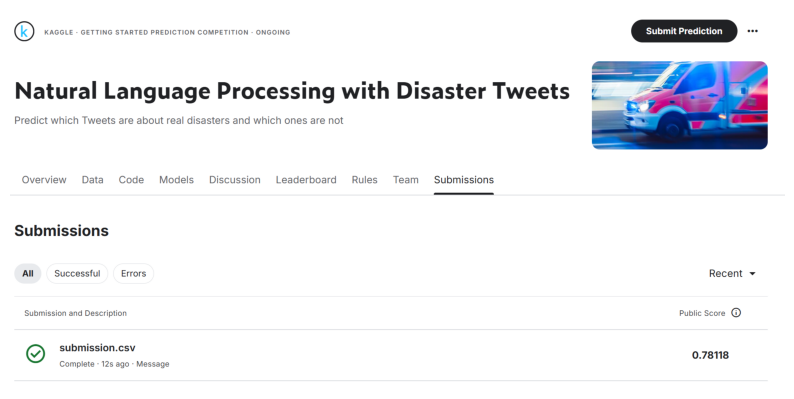

In [69]:
!pip install gdown
import gdown
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

url = 'https://drive.google.com/uc?id=1QLVEsu_FIxVX-8bUvzIutBpSHk_XRmOI'

output = 'downloaded_image.jpg'

gdown.download(url, output, quiet=False)

img = mpimg.imread(output)
plt.figure(figsize=(10,8))
plt.imshow(img)
plt.axis('off')
plt.show()

# Conclusion & Future Work
With a relatively simple recurrent neural network architecture, the model was able to achieve an F1 score of approximately 0.78. Many of the models gave similar results during training, with GRU-based models showing slightly better validation performance compared to LSTM models. This suggests that the GRU architecture's reduced complexity and faster training may make it more suitable for this task without sacrificing accuracy.

Further improvements could include:

* Data Augmentation: Expanding the dataset through augmentation techniques to increase model robustness.

* Hyperparameter Tuning: Exploring finer adjustments to learning rates, dropout rates, and batch sizes to optimize model convergence.

* Pretrained Embeddings: Incorporating pretrained word embeddings such as GloVe or Word2Vec could improve the model’s understanding of language structure.

* Attention Mechanism: Adding an attention layer could help the model focus on the most important parts of the input sequence, potentially improving accuracy and interpretability.

* Ensemble Methods: Combining predictions from multiple models (e.g., GRU and LSTM) could improve overall model robustness and performance.

Overall, the model demonstrates strong baseline performance with room for improvement through more sophisticated techniques and deeper hyperparameter exploration.

# Citation
Addison Howard, devrishi, Phil Culliton, and Yufeng Guo. Natural Language Processing with Disaster Tweets. https://kaggle.com/competitions/nlp-getting-started, 2019. Kaggle.